# Modeling

### Import Relevant Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [3]:
df = pd.read_parquet('./Data/processed_reports.parquet')

In [4]:
df.reset_index(inplace=True)

In [5]:
df.drop(['index'],axis=1,inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 99 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player                       4209 non-null   object 
 1   report                       4209 non-null   object 
 2   year                         4209 non-null   float64
 3   weight_x                     3986 non-null   float64
 4   height_x                     3986 non-null   float64
 5   pos_rk                       3871 non-null   float64
 6   ovr_rk                       3292 non-null   float64
 7   grade                        3877 non-null   float64
 8   age                          3897 non-null   float64
 9   Round                        4209 non-null   Int64  
 10  Pick                         4209 non-null   Int64  
 11  target                       4209 non-null   Int64  
 12  processed_report             4209 non-null   object 
 13  reportlen         

In [7]:
df['target'] = df.Round

In [8]:
df.target[df.target >= 6] = 0

In [9]:
df.target[df.target == 1] = 10

In [10]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [11]:
df.target[df.target == 3] = 2

In [12]:
df.target[df.target == 10] = 3

In [13]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [14]:
cleaned_df = cleaned_df.add_suffix('_col')

In [15]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


In [37]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.062,max_df =.75)

In [38]:
X = tf.fit_transform(df.joined_report)

In [39]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

In [40]:
report_df.columns

Index(['2002', '2003', '2004', '2005', '2006', '2016', 'abil', 'adequ', 'also',
       'appear',
       ...
       'two season', 'upsid', 'valu', 'versatil', 'well', 'work', 'yard',
       'year', 'year starter', 'zone'],
      dtype='object', length=198)

In [41]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

In [21]:
model_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,two,two season,upsid,versatil,well,work,yard,year,year starter,zone
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.318059,0.208009,0.0,0.000000
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,0.101353,0.0,0.0,0.129912,0.0,0.131897,0.342891,0.000000,0.0,0.000000
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.265581,0.115793,0.0,0.000000
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,0.088945,0.0,0.0,0.000000,0.0,0.000000,0.200609,0.000000,0.0,0.000000
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,0.127524,0.0,0.0,0.000000,0.0,0.000000,0.287623,0.062702,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,0.160185,0.0,0.0,0.205322,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.370394,0.000000,0.0,0.000000
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.245809


### Linear Regression

In [22]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('lin',LinearRegression())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
}

lin = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [23]:
lin.fit(X_train,y_train)
y_pred = lin.predict(X_test)
print(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.49087617609833367 2527.2484857536506


(0.0, 270.0)

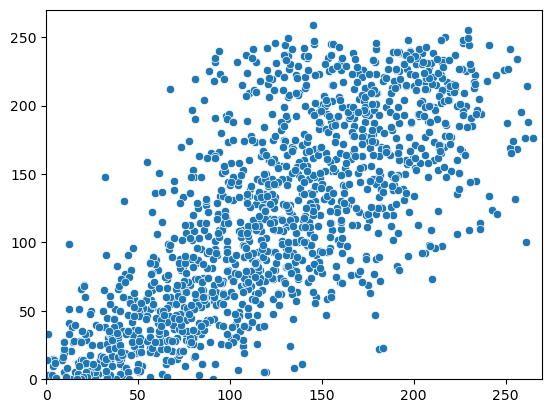

In [24]:
sns.scatterplot(y_pred,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

### Random Forest

In [28]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[99,97,98],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[21,22,23],
    'forest__min_samples_split':[3,2,1],
    'forest__min_samples_leaf':[4,5,6]
}

forest = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [29]:
forest.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
start_time = time.time()
forest.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_forest = forest.predict(X_test)
print(r2_score(y_test,y_pred_forest),mean_squared_error(y_test,y_pred_forest));

In [ ]:
sns.scatterplot(y_pred_forest,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

### KNN

In [71]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('knn',KNeighborsRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'knn__n_neighbors':[30,40]
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

knn = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [72]:
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
print(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\

0.49868519271605993 2488.4851741664374


In [ ]:
sns.scatterplot(y_pred_knn,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

### Decision Tree

In [73]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('tree',DecisionTreeRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)]
#     'tree__n_estimators':[75,100,125],
#     'tree__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'tree__max_depth':[4,12,None],
#     'tree__min_samples_split':[1,2,3],
#     'tree__min_samples_leaf':[1,2,3]
}

tree = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [74]:
tree.fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)
print(r2_score(y_test,y_pred_tree),mean_squared_error(y_test,y_pred_tree));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.3335330887272139 3308.2865370770337


In [ ]:
sns.scatterplot(y_pred_tree,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

### XGBoost

In [25]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('xgb',XGBRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'xgb__max_depth':[3,2,1],
    'xgb__eta':[.22,.23,.24],
    'xgb__gamma':[0,1,2]
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

xgb = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [29]:
xgb.best_params_

{'sample': RandomOverSampler(random_state=42),
 'xgb__eta': 0.23,
 'xgb__gamma': 0,
 'xgb__max_depth': 1}

In [26]:
start_time = time.time()
xgb.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_xgb = xgb.predict(X_test)
print(r2_score(y_test,y_pred_xgb),mean_squared_error(y_test,y_pred_xgb));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\cap

4.076668107509613 minutes
0.6360774994869666 1806.4811450090062


In [ ]:
sns.scatterplot(y_pred_xgb,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

### ADABoost

In [27]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('ada',AdaBoostRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'ada__n_estimators':[45,40],
    'ada__learning_rate':[.35,.33],
    'ada__loss':['linear','square','exponential']
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

ada = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [30]:
ada.best_params_

{'ada__learning_rate': 0.35,
 'ada__loss': 'linear',
 'ada__n_estimators': 40,
 'sample': RandomOverSampler(random_state=42)}

In [28]:
start_time = time.time()
ada.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_ada = ada.predict(X_test)
print(r2_score(y_test,y_pred_ada),mean_squared_error(y_test,y_pred_ada));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capt

6.8490630984306335 minutes
0.6331292333811261 1821.116093722432


In [ ]:
sns.scatterplot(y_pred_ada,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

### GradientBoost

In [61]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[94],
    'grad__learning_rate':[.05],
#     'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[2],
    'grad__min_samples_leaf':[1],
    'grad__max_depth':[4],
    'grad__min_impurity_decrease':[.31]
}

grad = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [62]:
start_time = time.time()
grad.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_grad = grad.predict(X_test)
print(r2_score(y_test,y_pred_grad),mean_squared_error(y_test,y_pred_grad));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.8689370671908061 minutes
0.6524671286024645 1725.1243838054565


In [55]:
grad.best_params_

{'grad__learning_rate': 0.05,
 'grad__max_depth': 4,
 'grad__min_impurity_decrease': 0.31,
 'grad__min_samples_leaf': 1,
 'grad__min_samples_split': 2,
 'grad__n_estimators': 94,
 'sample': RandomOverSampler(random_state=42)}

In [58]:
y_test

array([199, 151, 127, ..., 204,  71, 199])

In [59]:
y_pred_grad

array([208.03100677, 131.51236289, 176.39989632, ..., 199.99995066,
        60.21004735, 161.54142836])

In [63]:
player_pos

1073    DB
144     QB
2380    OL
184     RB
2587    LB
        ..
2282    WR
2986    DT
1078    DT
1413    LB
2696    OL
Name: pos_col, Length: 1389, dtype: object

In [65]:
y_test

array([199, 151, 127, ..., 204,  71, 199])

In [76]:
results = pd.concat([player_name.reset_index(),player_pos.reset_index(),player_round.reset_index(),player_year.reset_index(),X_test.reset_index(),pd.Series(y_pred_grad),pd.Series(y_test)],axis=1)

In [77]:
results

,index,player_col,index,pos_col,index,Round_col,index,year_col,index,weight_x_col,...,valu,versatil,well,work,yard,year,year starter,zone,0,1
0,1073,DeAndre Wright,1073,DB,1073,6,1073,2009.0,1073,198.0,...,0.00000,0.000000,0.287967,0.000000,0.000000,0.000000,0.000000,0.0,208.031007,199
1,144,Adrian McPherson,144,QB,144,5,144,2005.0,144,218.0,...,0.00000,0.000000,0.098724,0.000000,0.000000,0.083411,0.000000,0.0,131.512363,151
2,2380,Jon Feliciano,2380,OL,2380,4,2380,2015.0,2380,323.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,176.399896,127
3,184,DeAndra Cobb,184,RB,184,6,184,2005.0,184,196.0,...,0.00000,0.082646,0.000000,0.000000,0.218138,0.063405,0.000000,0.0,202.254711,200
4,2587,Kyler Fackrell,2587,LB,2587,3,2587,2016.0,2587,245.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,124.074491,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,2282,Phillip Dorsett,2282,WR,2282,1,2282,2015.0,2282,185.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,28.344223,28
1385,2986,Treyvon Hester,2986,DT,2986,7,2986,2017.0,2986,300.0,...,0.19871,0.000000,0.000000,0.165464,0.000000,0.250062,0.179509,0.0,188.018201,243
1386,1078,Ra'Shon Harris,1078,DT,1078,6,1078,2009.0,1078,298.0,...,0.00000,0.000000,0.000000,0.404393,0.000000,0.000000,0.000000,0.0,199.999951,204
1387,1413,Martez Wilson,1413,LB,1413,3,1413,2011.0,1413,250.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,60.210047,71


In [84]:
results['difference'] = results[0] - results[1]

In [85]:
results.difference

0        9.031007
1      -19.487637
2       49.399896
3        2.254711
4       37.074491
          ...    
1384     0.344223
1385   -54.981799
1386    -4.000049
1387   -10.789953
1388   -37.458572
Name: difference, Length: 1389, dtype: float64

In [86]:
results

,index,player_col,index,pos_col,index,Round_col,index,year_col,index,weight_x_col,...,versatil,well,work,yard,year,year starter,zone,0,1,difference
0,1073,DeAndre Wright,1073,DB,1073,6,1073,2009.0,1073,198.0,...,0.000000,0.287967,0.000000,0.000000,0.000000,0.000000,0.0,208.031007,199,9.031007
1,144,Adrian McPherson,144,QB,144,5,144,2005.0,144,218.0,...,0.000000,0.098724,0.000000,0.000000,0.083411,0.000000,0.0,131.512363,151,-19.487637
2,2380,Jon Feliciano,2380,OL,2380,4,2380,2015.0,2380,323.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,176.399896,127,49.399896
3,184,DeAndra Cobb,184,RB,184,6,184,2005.0,184,196.0,...,0.082646,0.000000,0.000000,0.218138,0.063405,0.000000,0.0,202.254711,200,2.254711
4,2587,Kyler Fackrell,2587,LB,2587,3,2587,2016.0,2587,245.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,124.074491,87,37.074491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,2282,Phillip Dorsett,2282,WR,2282,1,2282,2015.0,2282,185.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,28.344223,28,0.344223
1385,2986,Treyvon Hester,2986,DT,2986,7,2986,2017.0,2986,300.0,...,0.000000,0.000000,0.165464,0.000000,0.250062,0.179509,0.0,188.018201,243,-54.981799
1386,1078,Ra'Shon Harris,1078,DT,1078,6,1078,2009.0,1078,298.0,...,0.000000,0.000000,0.404393,0.000000,0.000000,0.000000,0.0,199.999951,204,-4.000049
1387,1413,Martez Wilson,1413,LB,1413,3,1413,2011.0,1413,250.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,60.210047,71,-10.789953
